In [3]:
import numpy as np
from scipy.integrate import quad
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import skew
import random

INPUT PARAMETERS DEFINITION

In [4]:
#S0 INITIAL SPOT PRICE
start = dt(2010,1,1)
end = dt.today()

# SP500
sp500_ts = yf.download('^GSPC', start = start, end=dt.today())
sp500_ts = sp500_ts['Close']

price_today = sp500_ts.values[-1]

# VVIX
vvix = yf.download("^VVIX", start = start, end=dt.today())
vvix = vvix['Close']

vvix_today = vvix.values[-1]

# Adjusting for missing dates
missing_dates = sp500_ts[~sp500_ts.index.isin(vvix.index)]
sp500_ts = sp500_ts.drop(missing_dates.index)

# Compute log returns on SP500 ts
sp500_logret = np.log(sp500_ts/sp500_ts.shift(1)).dropna()

# Compute log returns on VVIX ts
vvix_logret = np.log(vvix/vvix.shift(1)).dropna()

c:\Users\pc_hu\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\pc_hu\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [5]:
#r RISK FREE RATE
r = 0.0447

In [6]:
#kappa REVERSE MEAN COMPUTED USING AUTOCORRELATION METHOD
autocorr = sp500_logret.autocorr()
reverse_mean = np.round(np.log(-autocorr), 2)
print("Speed of reversion to the mean:",reverse_mean)

Speed of reversion to the mean: -2.12


In [7]:
#sigma VOLATILITY OF VARIANCE
print('Volatility of variance:',vvix_today)

Volatility of variance: 80.94000244140625


In [8]:
#Rho CORRELATION BETWEEN UNDERLYING AND HIS VARIANCE
corr_coef = np.round(np.corrcoef(sp500_logret.values, vvix_logret.values), 2)
print(corr_coef[0,1])

-0.61


HESTON MODEL PARAMETER DEFINITION

In [9]:
S0 = price_today    # initial spot price
V0 = 0.05   # initial variance
kappa = reverse_mean   # speed of reversion
theta = 0.083  # long term variance
sigma = np.std(vvix_logret)*(21**0.5)
rho = corr_coef[0,1]    # correlation between underlying and his variance
days = 21   # days to maturity

PUT OPTION PARAMETER DEFINITION

In [10]:
price_today

4868.5498046875

In [11]:
K = 4500.0     # Strike price found in Step 1

MONTE-CARLO SIMULATIONS

In [12]:
# Number of Monte-Carlo simulations
N = 6000000

# Monte-Carlo paths for price and varianxce
dt = 1/days
Z1 = np.random.randn(N, days)  #Random sampling from N(0,1)
Z2 = rho*Z1 + np.sqrt(1-rho**2)*np.random.randn(N, days)  #
S = np.zeros((N, days+1))
V = np.zeros((N, days+1))
S[:,0] = S0  #SPOT PRICE
V[:,0] = V0  #VARIANCE

margin_call = np.zeros(N, dtype=bool)  # initialize array to keep track of margin calls
M = 400 # Margin available

for i in range(days):
    dS = r*S[:,i]*dt + np.sqrt(V[:,i])*S[:,i]*np.sqrt(dt)*Z1[:,i] #Delta prezzo
    dV = kappa*(theta-V[:,i])*dt + sigma*np.sqrt(V[:,i])*np.sqrt(dt)*Z2[:,i] #Delta varianza
    S[:,i+1] = S[:,i] + dS  
    V[:,i+1] = V[:,i] + dV  
    V[:,i+1] = np.maximum(V[:,i+1], 0)  #Confronto la var della montecarlo al tempo t con 0, prendo il massimo o 0, non può essere negativa
    # calculate payoff at this step
    payoff = np.maximum(K - S[:, i+1], 0)
    
    # update margin_call array if payoff is greater than M
    margin_call = np.logical_or(margin_call, payoff > M)

In [13]:
# PAYOFF PUT OPTION
payoff = np.maximum(K-S[:,-1], 0)

# PROBABILITY ITM
prob = np.sum(payoff > 0)/N

print("Probability that option put will be ITM in one month's time::", prob)

# PROBABILITY OF MARGIN CALL
prob_margin_call = np.sum(margin_call) / N

print("Margin call probability:", prob_margin_call)



Probability that option put will be ITM in one month's time:: 0.16221816666666666
Margin call probability: 0.17958133333333334


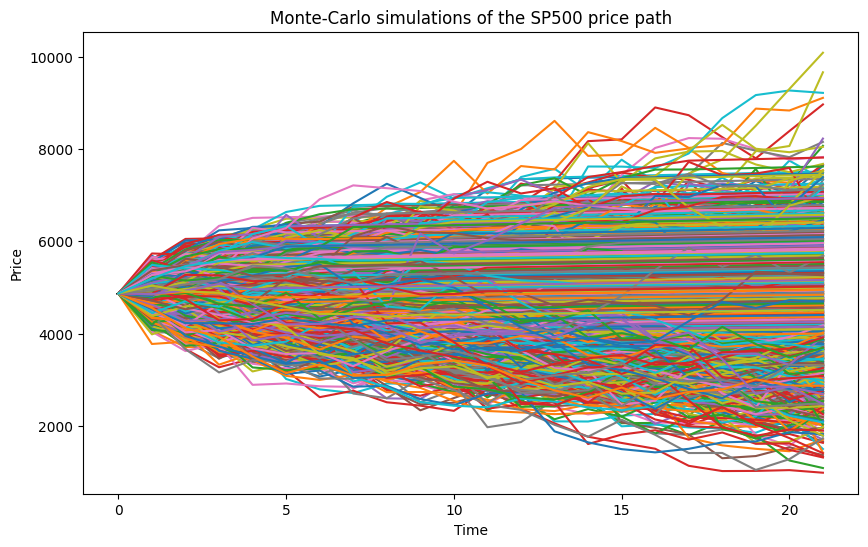

In [16]:
pool = random.sample(range(N), 10000)

plt.figure(figsize=(10,6))
for i in pool:
    plt.plot(S[i])

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Monte-Carlo simulations of the SP500 price path') 
plt.show()